In [164]:
import numpy as np
import pandas as pd

from skimage.io import imread
from skimage.transform import resize
from skimage.exposure import equalize_hist

import pydicom
from pydicom.data import get_testdata_files
import torch 
import os
from tensorboardX import SummaryWriter

from datasets import Brains
from models import UNet3D

# from utils

import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [165]:
from tqdm import tqdm

In [166]:
from models import UNet3D

In [167]:
#net = UNet3D(input_nc=1,output_nc=2)
#net.load_state_dict(torch.load('baseline_model_280epochs'))
#net=net.cuda();

In [168]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision.transforms as transforms
from torch.utils.data import Dataset

In [147]:
data = Brains(folder='../scanmasks-train/',crop=False)
#data = Brains(folder='../scanmasks-val/',crop=False)

In [148]:
len(data)

146

In [149]:
for i in range(len(data)):
    _,p = data[i]
    print(p.size())

torch.Size([1, 24, 512, 448])
torch.Size([1, 24, 512, 448])
torch.Size([1, 24, 512, 448])
torch.Size([1, 24, 512, 448])
torch.Size([1, 24, 512, 448])
torch.Size([1, 24, 512, 448])
torch.Size([1, 24, 512, 448])
torch.Size([1, 24, 512, 448])
torch.Size([1, 24, 512, 448])
torch.Size([1, 24, 512, 448])
torch.Size([1, 24, 512, 448])
torch.Size([1, 24, 512, 448])
torch.Size([1, 24, 512, 448])
torch.Size([1, 24, 512, 448])
torch.Size([1, 24, 512, 448])
torch.Size([1, 24, 512, 448])
torch.Size([1, 24, 512, 448])
torch.Size([1, 24, 512, 448])
torch.Size([1, 24, 512, 448])
torch.Size([1, 24, 512, 448])
torch.Size([1, 24, 512, 448])
torch.Size([1, 24, 512, 448])
torch.Size([1, 24, 512, 448])
torch.Size([1, 24, 512, 448])
torch.Size([1, 24, 512, 448])
torch.Size([1, 24, 512, 448])
torch.Size([1, 24, 512, 448])
torch.Size([1, 24, 512, 448])
torch.Size([1, 24, 512, 448])
torch.Size([1, 24, 512, 448])
torch.Size([1, 24, 512, 448])
torch.Size([1, 24, 512, 448])
torch.Size([1, 24, 512, 448])
torch.Size

KeyboardInterrupt: 

In [150]:
_,m = data[0]

In [151]:
mask = torch.zeros_like(m)[0]

In [152]:
mask.shape

torch.Size([24, 512, 448])

In [153]:
for i in tqdm(range(len(data))):
    _,next_mask = data[i]
    try:
        mask += next_mask[0]
    except:
        print('fu')

100%|██████████| 146/146 [00:21<00:00,  6.41it/s]

fu


In [154]:
mask = mask.numpy()
z = (mask != 0).astype(np.float32)

In [155]:
z.shape

(24, 512, 448)

In [156]:
zc=np.zeros_like(z)

In [157]:
from skimage.morphology import convex_hull

for i in range(z.shape[0]):
    zc[i] = convex_hull.convex_hull_image(z[i])

/root/.pyenv/versions/3.6.7/lib/python3.6/site-packages/skimage/morphology/convex_hull.py:53: UserWarning: Input image is entirely zero, no valid convex hull. Returning empty image
  "Returning empty image", UserWarning)


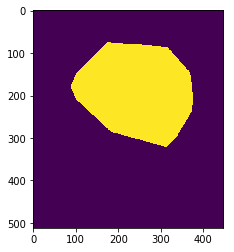

In [158]:
plt.imshow(zc[6])

In [159]:
p = z[6]

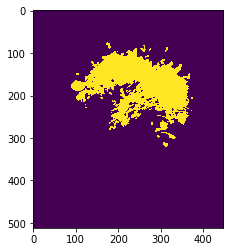

In [160]:
from skimage.morphology import closing, disk, dilation

c = dilation(closing(p, disk(20)), disk(4))

cs = [dilation(closing(z[i], disk(20)), disk(4)) for i in range(len(z))]

plt.imshow(p)

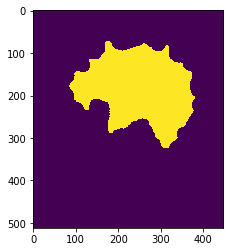

In [161]:
plt.imshow(c)

In [162]:
np.save('../convexmask',arr=zc)

In [163]:
np.save('../convexmask_close',arr=cs)

In [101]:
zzc=np.load('../convexmask.npy')

In [106]:
f=15

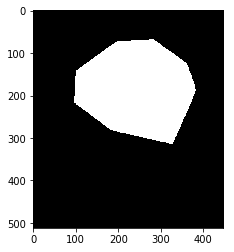

In [107]:
plt.imshow(zzc[f], cmap='gray')
f+=1

In [20]:
def test_sequential(image, model, size=64, stride=64, verbose=False):
    #image = float tensor from dataloader
    model.eval()
    
    out = torch.zeros_like(image)
    
    for i in range(image.shape[3]//size):
        for j in range(image.shape[4]//size):
            crop = image[:,:,:,i*size:(i + 1)*size,j*size:(j+1)*size]
            crop_predicted = model(Variable(crop).cuda())
            crop_predicted = crop_predicted.max(1, keepdim=True)[1]
            out[:,:,:,i*size:(i+1)*size,j*size: (j+1)*size] = crop_predicted.data
    
    return out

In [21]:
def dice_score(input, target):
    smooth = 1e-3
    iflat = input.reshape((input.size(0),-1))
    tflat = target.reshape((target.size(0),-1))
    intersection = (iflat * tflat).sum(1)
    
    return ((2. * intersection + smooth) / (iflat.sum(1) + tflat.sum(1) + smooth))

In [22]:
net = UNet3D(input_nc=1,output_nc=2)
net.load_state_dict(torch.load('baseline_model_280epochs'))
net=net.cuda();

In [23]:
data = Brains(crop=False)
datait = torch.utils.data.DataLoader(data, batch_size=2)

a, b = next(iter(datait))

In [24]:
a.shape

torch.Size([2, 1, 24, 512, 448])

In [25]:
aa=test_sequential(a,net)

In [26]:
aa.shape

torch.Size([2, 1, 24, 512, 448])

In [30]:
def postprocess(network_output, mask_path='../convexmask.npy'):
    
    mask = np.load(mask_path)
    
    postproc = torch.zeros_like(network_output)
    postproc[0] = torch.FloatTensor(mask)[None,...]
    postproc[1] = torch.FloatTensor(mask)[None,...]
    
    return network_output*postproc

In [31]:
re=postprocess(aa)

In [57]:
c=0

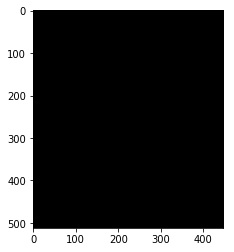

In [77]:
plt.imshow(re[1,0,c],cmap='gray')
c+=1

In [169]:
from skimage.morphology import closing, disk, dilation

In [170]:
mask = np.load('../convexmask.npy')

In [171]:
mask.shape

(24, 512, 448)

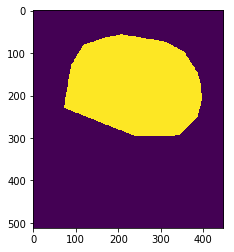

In [172]:
plt.imshow(mask[12])

In [183]:
s = disk(55)
mmask=dilation(mask[12],selem=s)

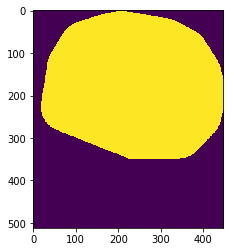

In [184]:
plt.imshow(mmask)

In [186]:
bmask = np.zeros_like(mask)
for i in tqdm(range(mask.shape[0])):
    bmask[i] = dilation(mask[i], selem=s)

100%|██████████| 24/24 [01:45<00:00,  4.57s/it]


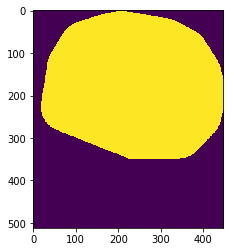

In [187]:
plt.imshow(bmask[12])

In [189]:
bmas = torch.LongTensor(bmask)

In [190]:
bmas.shape

torch.Size([24, 512, 448])

In [ ]:
np.save()

In [188]:
bmask.shape

(24, 512, 448)

In [196]:
mask_ext = torch.LongTensor(mask)
ppad = torch.zeros(24, 512, 40).long()
mask_ext = torch.cat([mask_ext, ppad],2)
mask_ext = mask_ext.numpy()

In [200]:
bmask = np.zeros_like(mask_ext)
for i in tqdm(range(mask_ext.shape[0])):
    bmask[i] = dilation(mask_ext[i], selem=s)

100%|██████████| 24/24 [02:57<00:00,  7.51s/it]


In [201]:
bmask.shape

(24, 512, 488)

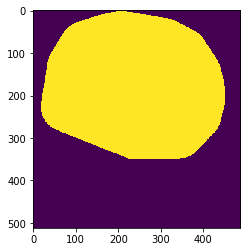

In [202]:
plt.imshow(bmask[12])

In [203]:
np.save('../convexmask_bedik.npy',bmask)

In [ ]:
data